In [7]:
import calibrator as cal
import chromadespill as chroma
import transfer_calibrator as tc
import transfer as tr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from ipywidgets import interact, FloatSlider, Layout
import importlib
import sklearn.metrics as sk


importlib.reload(cal)
importlib.reload(chroma)
importlib.reload(tc)
importlib.reload(tr)



<module 'transfer' from '/Users/robertocraparotta/Desktop/Tesi/Programma/transfer.py'>

## Plot compose image 

In [19]:
# FILE PATH
#foregroundPath = "Calibrator/Input/Image/*.png"
#backgroundPath = "Calibrator/Input/Background/*.png"

foregroundPath = "Calibrator/Input/Image/1.png"
backgroundPath = "Calibrator/Input/Background/1.png"

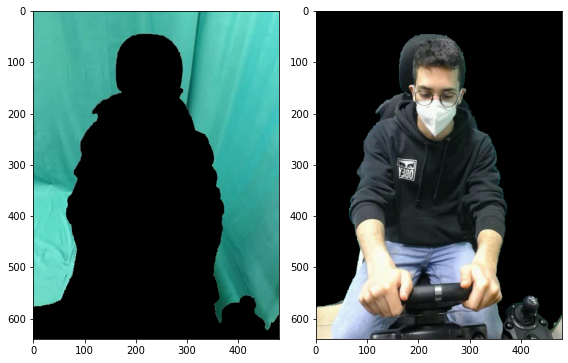

In [20]:
background, foreground = cal.loadAndComposeData(foregroundPath,backgroundPath)
fig,axes = plt.subplots(1,2, figsize=(8,8))
axes[0].imshow(cv2.cvtColor(background, cv2.COLOR_YCR_CB2RGB))
axes[1].imshow(cv2.cvtColor(foreground, cv2.COLOR_YCR_CB2RGB))
plt.tight_layout()
#plt.savefig('/Users/robertocraparotta/Desktop/fotocomposed.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

## Plot palette

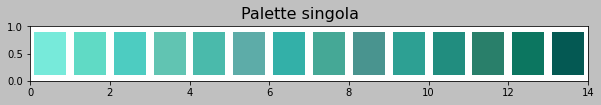

In [21]:
paletteYCbCr = cal.select_chroma_colors(background, foreground)
fig,ax = plt.subplots(1,1, figsize=(10,1), facecolor='silver')
for ii, clr in enumerate(paletteYCbCr):
    rgb = cv2.cvtColor(np.array([[clr]], np.uint8), cv2.COLOR_YCR_CB2RGB)[0,0,:]
    ax.add_patch(plt.Rectangle((ii+.1,0.1), 0.8, 0.8, lw=0, fc=rgb/255.0))
ax.set_ylim(0,1)
ax.set_xlim(0,ii+1)
plt.suptitle('Palette singola', fontsize=16, y=1.15)
#plt.savefig('/Users/robertocraparotta/Desktop/PaletteComposta.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('/Users/robertocraparotta/Desktop/PaletteComposed.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

## Plot YCB

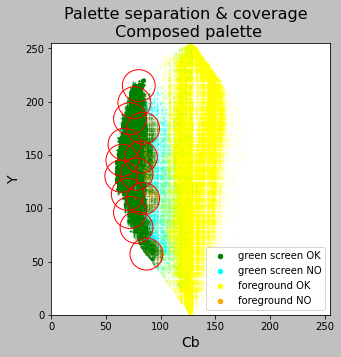

In [16]:
def plot_palette_YCB(backgroundYCbCr, foregroundYCbCr, palette):
    linB = cal.linearize_pixels(backgroundYCbCr)
    linF = cal.linearize_pixels(foregroundYCbCr)
    # remove from the background all black pixels (not part of the green screen)
    non_background = linB[:,0] > cal.BACKGROUND_MIN_Y_VALUE
    linB = linB[ non_background ]
    linF = linF[ ~non_background ]
    labels = ['Y', 'Cb']
    selB, selF = np.zeros_like(len(linB), bool), np.zeros_like(len(linF), bool)
    
    for clr in palette:
        selB = np.bitwise_or(selB, np.linalg.norm(linB - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
        selF = np.bitwise_or(selF, np.linalg.norm(linF - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
    
    fig = plt.figure(figsize=(5, 5), facecolor='silver')
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(0,255)
    plt.ylim(0,255)
    iX, iY = 1, 0
    plt.scatter(linB[selB,iX], linB[selB,iY], c='green', s=1, alpha=0.1, label='green screen OK')
    plt.scatter(linB[~selB,iX], linB[~selB,iY], c='cyan', s=1, alpha=0.1, label='green screen NO')
    plt.scatter(linF[~selF,iX], linF[~selF,iY], c='yellow', s=1, alpha=0.05, label='foreground OK')
    plt.scatter(linF[selF,iX], linF[selF,iY], c='orange', s=1, alpha=0.2, label='foreground NO')
    plt.xlabel(labels[iX], fontsize=14); 
    plt.ylabel(labels[iY], fontsize=14)
    # draw the palette colors
    for jj, palColor in enumerate(palette):
            circle = plt.Circle((palColor[iX], palColor[iY]), cal.CHROMA_RADIUS, color='r', fill=False)
            ax.add_patch(circle)
    lgnd = ax.legend(loc='best')
    for handle in lgnd.legendHandles:
        handle.set_sizes([20.0])
        handle.set_alpha(1)
    plt.suptitle('Palette separation & coverage\n Composed palette', fontsize=16)
    #plt.savefig('/Users/robertocraparotta/Desktop/YCB_Composta.svg',dpi=300, bbox_inches='tight',pad_inches=0.1)
    #plt.savefig('/Users/robertocraparotta/Desktop/YCB_Composta.png', dpi=300 ,bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
plot_palette_YCB(background, foreground, paletteYCbCr)

## Plot palette separation and coverage

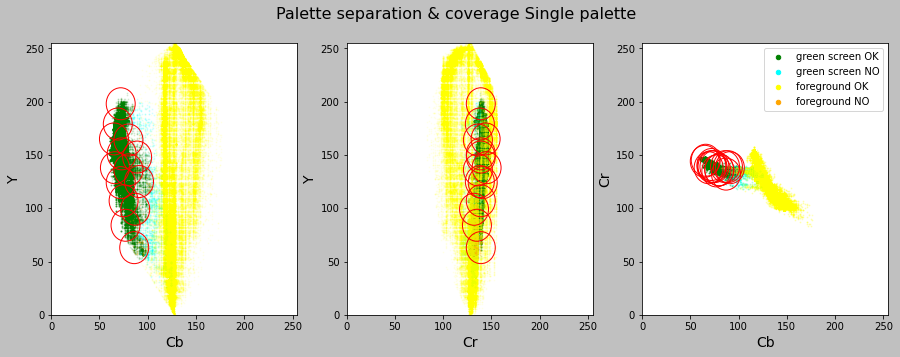

In [34]:
def plot_palette_coverage(backgroundYCbCr, foregroundYCbCr, palette):
    linB = cal.linearize_pixels(backgroundYCbCr)
    linF = cal.linearize_pixels(foregroundYCbCr)
    # remove from the background all black pixels (not part of the green screen)
    non_background = linB[:,0] > cal.BACKGROUND_MIN_Y_VALUE
    linB = linB[ non_background ]
    linF = linF[ ~non_background ]
    labels = ['Y', 'Cb', 'Cr']
    selB, selF = np.zeros_like(len(linB), bool), np.zeros_like(len(linF), bool)
    
    for clr in palette:
        selB = np.bitwise_or(selB, np.linalg.norm(linB - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
        selF = np.bitwise_or(selF, np.linalg.norm(linF - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
    
    fig,axes = plt.subplots(1,3, figsize=(15, 5), facecolor='silver')
    for ii, ax in enumerate(axes):
        ax.set_xlim(0,255)
        ax.set_ylim(0,255)
        if   ii==0: iX, iY = 1, 0
        elif ii==1: iX, iY = 2, 0
        elif ii==2: iX, iY = 1, 2
        ax.scatter(linB[selB,iX], linB[selB,iY], c='green', s=1, alpha=0.1, label='green screen OK')
        ax.scatter(linB[~selB,iX], linB[~selB,iY], c='cyan', s=1, alpha=0.1, label='green screen NO')
        ax.scatter(linF[~selF,iX], linF[~selF,iY], c='yellow', s=1, alpha=0.05, label='foreground OK')
        ax.scatter(linF[selF,iX], linF[selF,iY], c='orange', s=1, alpha=0.2, label='foreground NO')
        ax.set_xlabel(labels[iX], fontsize=14); 
        ax.set_ylabel(labels[iY], fontsize=14)
        # draw the palette colors
        for jj, palColor in enumerate(palette):
                circle = plt.Circle((palColor[iX], palColor[iY]), cal.CHROMA_RADIUS, color='r', fill=False)
                ax.add_patch(circle)
        if ii==2: 
            lgnd = ax.legend()
            for handle in lgnd.legendHandles:
                handle.set_sizes([20.0])
                handle.set_alpha(1)
    #plt.suptitle('Palette separation & coverage Single palette', fontsize=16)
    #plt.savefig('/Users/robertocraparotta/Desktop/Table_NOComposta.png', dpi=300 ,bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_palette_coverage(background, foreground, paletteYCbCr)

## Plot 3d Colorspace

In [3]:
imgPath = "Calibrator/Input/Image/1.png"
imgName = 'Me'
palettePath = 'Calibrator/Output/palette.txt'


In [51]:
%matplotlib notebook  
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go 
import matplotlib.animation as animation
init_notebook_mode (connected=True)

def ExtractBgFg(imageBGR):
    imageYCbCr = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2YCR_CB)
    invertedMask = 1-(chroma.chroma_mask_palette_ramped(imageYCbCr,palettePath))
    invertedMask = invertedMask[:,:] == 0
    Fg = deepcopy(imageBGR)
    Bg = deepcopy(imageBGR)
    Bg[ invertedMask ] = (0,0,0)
    Fg[ ~invertedMask ] = (0,0,0)
    bgYCbCr = cv2.cvtColor(Bg, cv2.COLOR_BGR2YCR_CB)
    fgYCbCr = cv2.cvtColor(Fg, cv2.COLOR_BGR2YCR_CB)
    return bgYCbCr, fgYCbCr

def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

def plot_palette_coverage3(backgroundYCbCr, foregroundYCbCr, palette, despillMask, title):
    linB = cal.linearize_pixels(backgroundYCbCr)
    linF = cal.linearize_pixels(foregroundYCbCr)
    non_background = linB[:,0] > cal.BACKGROUND_MIN_Y_VALUE
    linB = linB[ non_background ]
    linF = linF[ ~non_background ]
    labels = ['Y', 'Cb', 'Cr']
    selB, selF = np.zeros_like(len(linB), bool), np.zeros_like(len(linF), bool)

    for clr in palette:
        selB = np.bitwise_or(selB, np.linalg.norm(linB - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
        selF = np.bitwise_or(selF, np.linalg.norm(linF - clr, axis=1, ord=2) < cal.CHROMA_RADIUS)
    
    num_points = len(selB) + len(selF)
    ratio = 2000.0 / num_points
    print(ratio)

    BIdxT, BIdxF = np.where(selB)[0], np.where(~selB)[0]
    FIdxT, FIdxF = np.where(selF)[0], np.where(~selF)[0]
    BT = np.random.choice(BIdxT, int(len(BIdxT) * ratio * 10))
    BF = np.random.choice(BIdxF, int(len(BIdxF) * ratio * 10))
    FT = np.random.choice(FIdxT, int(len(FIdxT) * ratio * 10))
    FF = np.random.choice(FIdxF, int(len(FIdxF) * ratio * 10))

    DIdxT = np.where(despillMask)[0]
    DT = np.random.choice(DIdxT, int(len(DIdxT) * ratio)) 

    totLen = len(linF) + len(linB)
    BTperc = (len(BIdxT)*100)/totLen
    BFperc = (len(BIdxF)*100)/totLen
    FTperc = (len(FIdxT)*100)/totLen
    FFperc = (len(FIdxF)*100)/totLen
    Despillperc = ((len(DIdxT))*100)/totLen
    

    
    trace1 = go.Scatter3d(name = 'green screen OK: %.2f%%' % round(BTperc,2), x=linB[BT,0], y=linB[BT,1], z=linB[BT,2], mode = 'markers', marker = dict(size = 1.5, color = 'green'))
    trace2 = go.Scatter3d(name = 'green screen NO: %.2f%%' % round(BFperc,2), x=linB[BF,0], y=linB[BF,1], z=linB[BF,2], mode = 'markers', marker = dict(size = 1.5, color = 'cyan'))
    trace3 = go.Scatter3d(name = 'foreground OK: %.2f%%' % round(FFperc,2), x=linF[FF,0], y=linF[FF,1], z=linF[FF,2], mode = 'markers', marker = dict(size = 1.5, color = 'yellow'))
    trace4 = go.Scatter3d(name = 'foreground NO: %.2f%%' % round(FTperc,2), x=linF[FT,0], y=linF[FT,1], z=linF[FT,2], mode = 'markers', marker = dict(size = 1.5, color = 'orange'))
    trace5 = go.Scatter3d(name = 'Despill: %2.f%%' % round(Despillperc,2), x=linF[DT,0], y=linF[DT,1], z=linF[DT,2], mode = 'markers', marker = dict(size = 1.5, color = 'red')) 

    data = [trace1,trace2,trace3,trace4,trace5]

    layout = go.Layout(scene = dict(xaxis_title='Y', yaxis_title='Cb', zaxis_title='Cr'), width=600, height=500, margin=dict(r=10, b=10, l=10, t=10))

    fig = go.Figure(data = data, layout = layout)

    ## animation
    x_eye = -1.25
    y_eye = 2
    z_eye = 0.5

    fig.update_layout(
            title=title,
            scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
            updatemenus=[dict(type='buttons',
                    showactive=False,
                    y=1,
                    x=0.8,
                    xanchor='left',
                    yanchor='bottom',
                    pad=dict(t=45, r=10),
                    buttons=[dict(label='Play',
                                    method='animate',
                                    args=[None, dict(frame=dict(duration=5, redraw=True), 
                                                                transition=dict(duration=0),
                                                                fromcurrent=True,
                                                                mode='immediate'
                                                                )]
                                                )
                                        ]
                                )
                            ]
    )

    frames=[]
    for t in np.arange(0, 6.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
    fig.frames=frames
    #fig.write_html("/Users/robertocraparotta/Desktop/try.html")
    fig.show()
    
img = cv2.imread(imgPath,cv2.IMREAD_UNCHANGED)
DespillMask,_ = chroma.despill2(img, sensitivity=0.95,doRamp=False)

_,_,DespillMask,_ = chroma.applyChromaDespill(img,_, palettePath, 0, 0, 100, 0,0,borderSz=2, sensitivity=0.95, applyDespill=True, addBorder=True, doRamp=True, applyTransfer=False)

bgYCbCr,fgYCbCr = ExtractBgFg(img)
plot_palette_coverage3(bgYCbCr, fgYCbCr, paletteYCbCr,DespillMask, title = 'Color space:%s' % imgName)
fg = cv2.cvtColor(fgYCbCr, cv2.COLOR_YCR_CB2BGR)
_,FG = chroma.despill2(fg, sensitivity=0.95, doRamp = False)
FG = cv2.cvtColor(FG, cv2.COLOR_BGR2YCR_CB)
plot_palette_coverage3(bgYCbCr, FG, paletteYCbCr, DespillMask,  title = 'Color space:%s Despilled' % imgName)

0.006510416666666667


0.006510416666666667


## Interactive play with the main parameters

interactive(children=(FloatSlider(value=2.0, description='borderSz', layout=Layout(width='500px'), max=5.0, st…

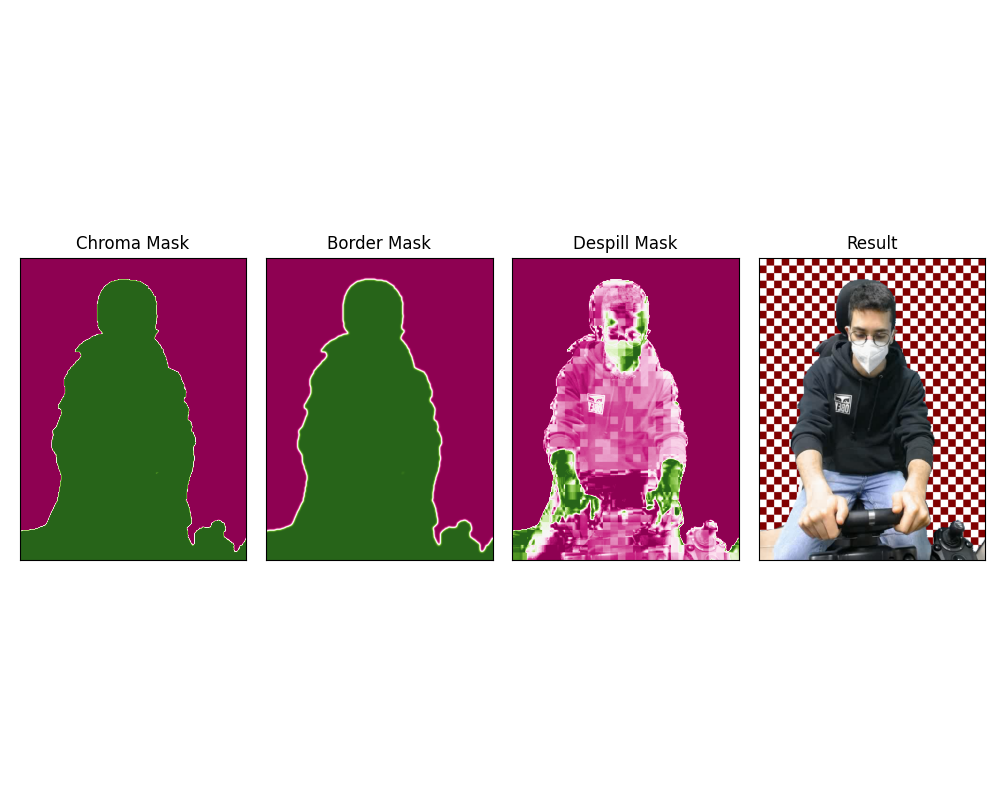

In [17]:
%matplotlib widget

base_image_BGR = cv2.imread(imgPath)
newBackground = chroma.checkboard(np.zeros_like(base_image_BGR, dtype=np.uint8))

fig, axes = plt.subplots(1,4, figsize=(10,8))
titles = ['Chroma Mask', 'Border Mask', 'Despill Mask', 'Result']
for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(0, base_image_BGR.shape[0])
    ax.set_ylim(0, base_image_BGR.shape[1])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.set_title('X')
plt.tight_layout()

def update1(borderSz, sensitivity, applyDespill, addBorder, doRamp):
    global axes, fig
    mask, borderMask, despMask, image = chroma.applyChromaDespill(base_image_BGR, newBackground, palettePath, 0, 0, 100, None, None, borderSz, sensitivity, applyDespill, addBorder, doRamp, False)
    for ax, t in zip(axes, titles): 
        ax.clear()
        ax.set_title(t)
    axes[0].imshow(mask, cmap="PiYG", vmin=0, vmax=1)
    axes[1].imshow(borderMask, cmap="PiYG", vmin=0, vmax=1)
    axes[2].imshow(despMask, cmap="PiYG", vmin=0, vmax=1)
    axes[3].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.savefig('/Users/robertocraparotta/Desktop/PaletteComposta.pdf', bbox_inches='tight', pad_inches=0.1)
    #imag = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('/Users/robertocraparotta/Desktop/NoDespill.png',image)
    fig.canvas.draw()

layout=Layout(width='500px')
_=interact(update1,
           borderSz=FloatSlider(min=0, max=5, step=0.2, value=2, layout=layout), 
           sensitivity=FloatSlider(min=0, max=2, step=0.05, value=0.95, layout=layout),
           applyDespill=True, addBorder=True, doRamp=True)

## Interactive play with the parameters to calculate transfer stats

interactive(children=(FloatSlider(value=1.0, description='lMeanM', layout=Layout(width='500px'), max=2.0, step…

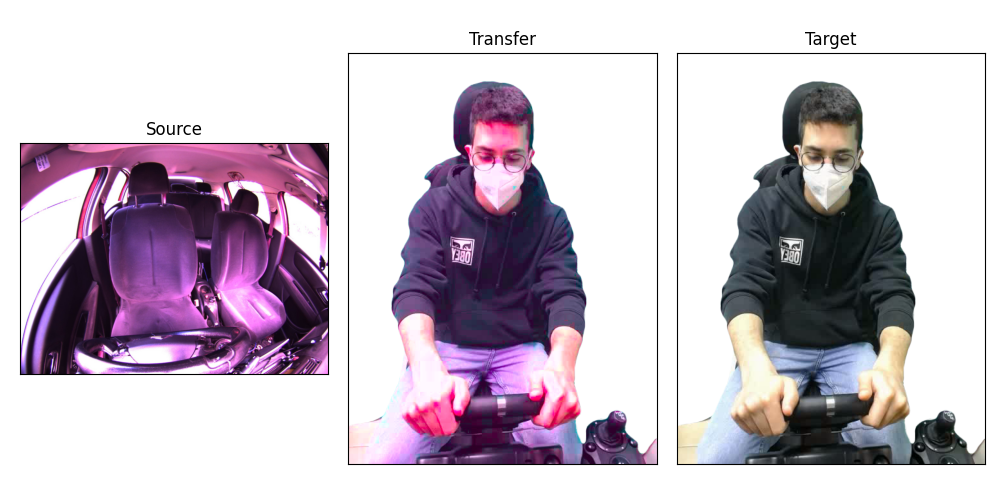

In [15]:
from matplotlib.widgets import Button
%matplotlib widget

source = cv2.imread('TransferCalibrator/Input/Source.png')
target = cv2.imread('TransferCalibrator/Input/Target.png', cv2.IMREAD_UNCHANGED)


sourceStats = tc.image_stats(source)

fig, axes = plt.subplots(1,3, figsize=(10,5))
titles = ['Source', 'Transfer', 'Target']
for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_xlim(0, base_image_BGR.shape[0])
    #ax.set_ylim(0, base_image_BGR.shape[1])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.set_title('X')
plt.tight_layout()

def update(lMeanM, lStdM, aMeanM, aStdM, bMeanM, bStdM, preserve_paper, save):
    global axes, fig
    # Gioco, usando gli slider, con i parametri (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) 
    # attraverso un moltiplicatore(?) chiamando image_stats(); Un moltiplicaotre per ogni parametro
    targetStats = tc.image_stats(target,True,lMeanM, lStdM, aMeanM, aStdM, bMeanM, bStdM)
    
    # Con i dati che mi restituisce image_stats() chiamo color_transfer()
    transfer = tr.color_transfer(target, sourceStats, targetStats, preserve_paper)
    
    mask = target[:,:,3]
    transfer = cv2.cvtColor(transfer, cv2.COLOR_BGR2BGRA)
    transfer[:,:,3] = mask
    
    # Se il risultato mi piace salvo i dati
    if save:
        np.savetxt('TransferCalibrator/Output/SourceStats.txt', sourceStats)
        np.savetxt('TransferCalibrator/Output/TargetStats.txt', targetStats)
        print("TRANSFER STATS SAVED!")
    
    # Visualizzo a video il risultato dell'immagine composta con lo sfondo/ affiancata dallo sfondo
    for ax, t in zip(axes, titles): 
        ax.clear()
        ax.set_title(t)
    axes[0].imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
    axes[1].imshow(cv2.cvtColor(transfer, cv2.COLOR_BGRA2RGBA))
    axes[2].imshow(cv2.cvtColor(target, cv2.COLOR_BGRA2RGBA))
    #cv2.imwrite("/Users/robertocraparotta/Downloads/Transfer.png", transfer)
    #cv2.imwrite("/Users/robertocraparotta/Downloads/Source.png", source)
    #cv2.imwrite("/Users/robertocraparotta/Downloads/Target.png", target)
    #plt.savefig('/Users/robertocraparotta/Desktop/TransferRRa.pdf', bbox_inches='tight', pad_inches=0.1)
    fig.canvas.draw()

layout=Layout(width='500px')
_=interact(update,
           lMeanM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           lStdM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           aMeanM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           aStdM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           bMeanM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           bStdM=FloatSlider(min=0, max=2, step=0.05, value=1, layout=layout),
           preserve_paper=False, save=False)



## Plot calibration table

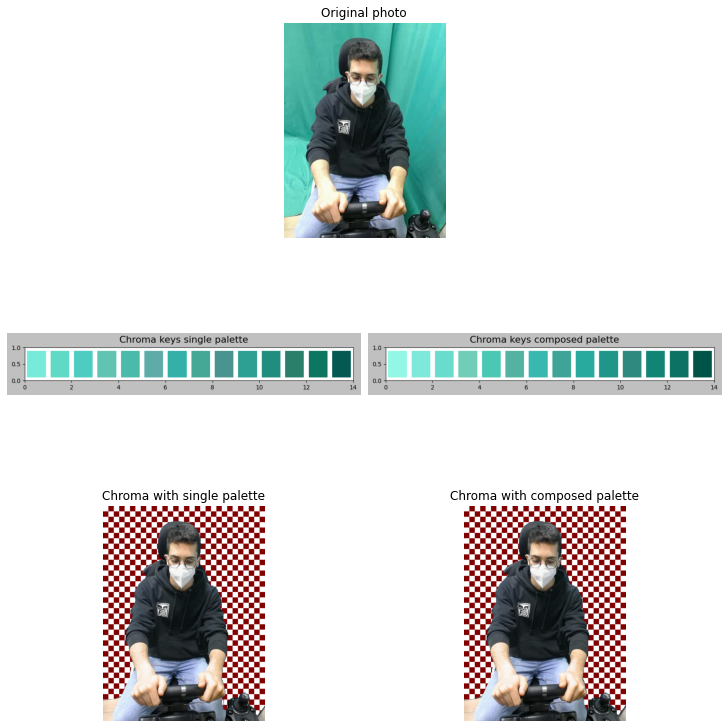

In [30]:
fig = plt.figure(constrained_layout=True,figsize=(10,10))
subfig = fig.subfigures(3,1)

#IMMAGINE ORIGINALE
subfig0 = subfig[0].subplots(1,1)
subfig0.title.set_text('Original photo')
subfig0.axes.get_xaxis().set_visible(False)
subfig0.axes.get_yaxis().set_visible(False)
subfig0.axes.axis("off")
img0 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/ME/ME.png' ,cv2.IMREAD_UNCHANGED)  
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
subfig0.imshow(img0)

#PALETTE SUE E COMPOSTA
subfig1 = subfig[1].subplots(1,2)
for i in range(2):
    subfig1[i].axes.get_xaxis().set_visible(False)
    subfig1[i].axes.get_yaxis().set_visible(False)
    subfig1[i].axes.axis("off")
paletteMe = cv2.imread('/Users/robertocraparotta/Desktop/PaletteMe.png')
paletteMe = cv2.cvtColor(paletteMe, cv2.COLOR_BGR2RGB)
paletteComposta = cv2.imread('/Users/robertocraparotta/Desktop/PaletteComposta.png')
paletteComposta = cv2.cvtColor(paletteComposta, cv2.COLOR_BGR2RGB)
subfig1[0].imshow(paletteMe)
subfig1[1].imshow(paletteComposta)

#IMMAGINE ELABORATA CON PALETTE SUA E COMPOSTA
subfig2 = subfig[2].subplots(1,2)
subfig2[0].title.set_text('Chroma with single palette')
subfig2[1].title.set_text('Chroma with composed palette')
for i in range(2):
    subfig2[i].axes.axis("off")
    subfig2[i].axes.get_xaxis().set_visible(False)
    subfig2[i].axes.get_yaxis().set_visible(False)
#MeChroma = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Me/MeNBGFrame.png',cv2.IMREAD_UNCHANGED)
#MeChroma = cv2.cvtColor(MeChroma, cv2.COLOR_BGRA2RGBA)
#MeChromaComposta = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Me/MeChromaBorderComposedPalette.png',cv2.IMREAD_UNCHANGED)
#MeChromaComposta = cv2.cvtColor(MeChromaComposta, cv2.COLOR_BGRA2RGBA)


MeChroma = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Confronti Palette composta/MePaletteMe.png')
MeChroma = cv2.cvtColor(MeChroma, cv2.COLOR_BGR2RGB)
MeChromaComposta = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Confronti Palette composta/MePaletteComposta.png')
MeChromaComposta = cv2.cvtColor(MeChromaComposta, cv2.COLOR_BGR2RGB)

subfig2[0].imshow(MeChroma)
subfig2[1].imshow(MeChromaComposta)


#GRAFICO YCB CON PALETTE SUA E COMPOSTA
#subfig3 = subfig[3].subplots(1,2)
#for i in range(2):
#    subfig3[i].axes.get_xaxis().set_visible(False)
#    subfig3[i].axes.get_yaxis().set_visible(False)
#    subfig3[i].axes.axis("off")
#ycbMe = cv2.imread('/Users/robertocraparotta/Desktop/YCB_Me.png')
#ycbMe = cv2.cvtColor(ycbMe, cv2.COLOR_BGR2RGB)
#ycbMeComposta = cv2.imread('/Users/robertocraparotta/Desktop/YCB_MeComposta.png')
#ycbMeComposta = cv2.cvtColor(ycbMeComposta, cv2.COLOR_BGR2RGB)
#subfig3[0].imshow(ycbMe)
#subfig3[1].imshow(ycbMeComposta)

plt.savefig('/Users/robertocraparotta/Desktop/CalibrationTableChess1.pdf', bbox_inches='tight', pad_inches=0.1)




## Plot single confusion matrix 

In [ ]:
from sklearn.svm import SVC

true = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/Me/Photoshop.png', cv2.IMREAD_UNCHANGED)
true = true.astype(float)
true = true[:,:,3]/255
true = classifier(true)

pred = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/Me/AlphaDaVinci.png', cv2.IMREAD_UNCHANGED)
pred = pred.astype(float)
pred = pred[:,:,3]/255
pred = classifier(pred, 0.15)

display(pred)
display(true)

cm = sk.confusion_matrix(true, pred)
disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['B', 'F', 'E'])
disp.plot()
plt.tight_layout()
plt.title("Confusion matrix Old\n MePhotoshop - DaVinci Resolve")
plt.savefig('/Users/robertocraparotta/Desktop/Me_Old_Matrix_Photoshop_DaVinci.png', dpi=150, bbox_inches='tight', pad_inches=0.1)


## Plot Hystogram

In [ ]:
alphaChroma = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/Prof/AlphaDaVinci.png' ,cv2.IMREAD_UNCHANGED)
#alphaChroma = cv2.cvtColor(alphaChroma, cv2.COLOR_BGR2BGRA)
alphaChroma = alphaChroma.astype(float)
alphaChroma = alphaChroma[:,:,3]/255

plt.hist(alphaChroma.ravel(),bins=64, rwidth=0.7)
plt.yscale('log')
plt.axvline(0.18, c='r')
plt.text(0.18, 10000, 'Delta = 0.001')
plt.axvline(0.99, c='r')
plt.xlim([-0.05, 1.05])
plt.xlabel('alpha channel value')
plt.ylabel('Density (log)')
plt.title('Alpha channel histogram of MeAlphaChannel')
plt.savefig('/Users/robertocraparotta/Desktop/B.png',dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

## Plot Chroma table

In [ ]:

def imgToColorMap(img , i=1 , deltaSx=0.01, deltaDx=0.99):
    deltaSx = int(deltaSx * 255)
    deltaDx = int(deltaDx * 255)
    if(i==1):
        img[:,:,0] = np.where((img[:,:,3] >= 0 ) & (img[:,:,3] <= deltaSx), 232, img[:,:,0])
        img[:,:,1] = np.where((img[:,:,3] >= 0 ) & (img[:,:,3] <= deltaSx), 232, img[:,:,1])
        img[:,:,2] = np.where((img[:,:,3] >= 0 ) & (img[:,:,3] <= deltaSx), 232, img[:,:,2])

        img[:,:,0] = np.where((img[:,:,3] >= deltaDx ) & (img[:,:,3] <= 255), 255, img[:,:,0])
        img[:,:,1] = np.where((img[:,:,3] >= deltaDx ) & (img[:,:,3] <= 255), 255, img[:,:,1])
        img[:,:,2] = np.where((img[:,:,3] >= deltaDx ) & (img[:,:,3] <= 255), 255, img[:,:,2])


        img[:,:,0] = np.where((img[:,:,3] > deltaSx ) & (img[:,:,3] < deltaDx), 255, img[:,:,0])
        img[:,:,1] = np.where((img[:,:,3] > deltaSx ) & (img[:,:,3] < deltaDx), 0, img[:,:,1])
        img[:,:,2] = np.where((img[:,:,3] > deltaSx ) & (img[:,:,3] < deltaDx), 0, img[:,:,2])

    elif(i==2):
        img[:,:,0] = np.where(img[:,:,3] == 0 , 255, img[:,:,0])
        img[:,:,1] = np.where(img[:,:,3] == 0 , 0, img[:,:,1])
        img[:,:,2] = np.where(img[:,:,3] == 0 , 0, img[:,:,2])

        img[:,:,0] = np.where(img[:,:,3] == 255, 0, img[:,:,0])
        img[:,:,1] = np.where(img[:,:,3] == 255, 0, img[:,:,1])
        img[:,:,2] = np.where(img[:,:,3] == 255, 255, img[:,:,2])


        img[:,:,0] = np.where( (img[:,:,3] != 0 ) & (img[:,:,3] != 255), 0, img[:,:,0])
        img[:,:,1] = np.where( (img[:,:,3] != 0 ) & (img[:,:,3] != 255), 255, img[:,:,1])
        img[:,:,2] = np.where( (img[:,:,3] != 0 ) & (img[:,:,3] != 255), 0, img[:,:,2])
        
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    return img
    

In [ ]:
from sklearn.svm import SVC

subject = ['Karate','KungFu','OldMan','Scientist','Me','Prof','Seat']

for subject in subject:
    name = ['Original name','Ground truth','DaVinci','Script border','Script no border']

    if subject == 'Me' or subject == 'Prof' or subject == 'Seat':
        gT = 'Photoshop'
    else:
        gT = 'Paper'

    img0 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/Original.png' % subject ,cv2.IMREAD_UNCHANGED)  
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGRA2RGBA)
    hist0 = hista(img0)

    img1 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/%s.png' % (subject,gT)  ,cv2.IMREAD_UNCHANGED)  
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2RGBA)
    hist1 = hista(img1)
    img1 = imgToColorMap(img1)

    img2 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/AlphaDaVinci.png' % subject ,cv2.IMREAD_UNCHANGED)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2RGBA)
    hist2 = hista(img2)
    img2 = imgToColorMap(img2,deltaSx=0.18)
    img3 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/Chroma.png' % subject ,cv2.IMREAD_UNCHANGED)  
    img3 = cv2.cvtColor(img3, cv2.COLOR_BGRA2RGBA)
    hist3 = hista(img3)
    img3 = imgToColorMap(img3)
    img4 = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/ChromaNoBorder.png' % subject ,cv2.IMREAD_UNCHANGED)  
    img4 = cv2.cvtColor(img4, cv2.COLOR_BGRA2RGBA)
    hist4 = hista(img4)
    img4 = imgToColorMap(img4)


    subfig, axs = plt.subplots(2,5)
    #subfig.figure(constrained_layout=True,figsize=(10,10))
    subfig.set_figheight(15)
    subfig.set_figwidth(25)

    for i in range(5):
        axs[0,i].axes.get_xaxis().set_visible(False)
        axs[0,i].axes.get_yaxis().set_visible(False)
        axs[0,i].set_title(name[i],fontsize= 'xx-large')
        axs[0,i].axis("off")
    axs[0, 0].imshow(img0)
    axs[0, 1].imshow(img1)
    axs[0, 2].imshow(img2)
    axs[0, 3].imshow(img3)
    axs[0, 4].imshow(img4)

    for i in range(1,5):
        #if(i!=1):
            #axs[1,i].axes.get_yaxis().set_visible(False)
            #axs[1,i].spines["left"].set_visible(False)
        axs[1,i].spines["right"].set_visible(False)
        axs[1,i].spines["top"].set_visible(False)
        axs[1,i].set_yscale('log')
        axs[1,i].set_xscale('linear')
        axs[1,i].set_xlim([-0.1, 1.1])
        axs[1, i].set_xlabel('alpha channel value',fontsize= 'xx-large')
        axs[1, 1].set_ylabel('Density (log)',fontsize= 'xx-large')
        if(i==2):
            deltaSx = 0.18
            deltaDx = 0.99
        else:
            deltaSx = 0.01
            deltaDx = 0.99
        axs[1, i].axvline(deltaSx, c='r')
        axs[1, i].text(deltaSx+0.05, 70000, 'DeltaSx = %s' % deltaSx,fontsize= 'large')
        axs[1, i].text(0.5, 25000, 'DeltaDx = %s' % deltaDx,fontsize= 'large')
        axs[1, i].axvline(deltaDx, c='r')
        axs[1, i].set_xlim([-0.05, 1.05])
        axs[1, i].set_ylim([-0.01, 1000000])
        axs[1, i].set_title('Alpha channel histogram',fontsize= 'xx-large')
        axs[1, i].tick_params(axis='both', which='major', labelsize=12)

    axs[1,0].axis("off")
    #axs[1, 0].hist(hist0.ravel(),bins=64)
    axs[1, 1].hist(hist1.ravel(),bins=64)
    axs[1, 2].hist(hist2.ravel(),bins=64)
    axs[1, 3].hist(hist3.ravel(),bins=64)
    axs[1, 4].hist(hist4.ravel(),bins=64)

    plt.savefig('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/ChromaPlot/%sPlotA.pdf' % subject, bbox_inches='tight', pad_inches=0.1)





In [ ]:
def hista(alphaChroma):
    alphaChroma = cv2.cvtColor(alphaChroma, cv2.COLOR_BGR2BGRA)
    alphaChroma = alphaChroma.astype(float)
    alphaChroma = alphaChroma[:,:,3]/255
    

    return alphaChroma

## Photo composer

In [87]:
frame = ['Me','Prof','Seat','KungFu','Karate','OldMan','Scientist']

for f in frame:
    if f == 'Me' or f == 'Prof' or f == 'Seat':
        palettePathh = 'Calibrator/Output/palette.txt'
    if f == 'KungFu': 
        palettePathh = '/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/KungFu/paletteKungFu.txt'
    if f == 'Karate': 
        palettePathh = '/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Karate/paletteKarate.txt'
    if f == 'OldMan': 
        palettePathh = '/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/OldMan/paletteOldMan.txt'
    if f == 'Scientist':
        palettePathh = '/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Scientist/paletteScientist.txt'
        
    base_image_BGR = cv2.imread('/Users/robertocraparotta/Desktop/Chess/%s.png' % f, cv2.IMREAD_UNCHANGED)
    #base_image_BGR = cv2.cvtColor(base_image_BGR, cv2.COLOR_BGR2BGRA)
    #newBackground = np.zeros_like(base_image_BGR, dtype=np.uint8)
    newBackground = chroma.checkboard(np.zeros_like(base_image_BGR, dtype=np.uint8))
    _, _, _, image = chroma.applyChromaDespill(base_image_BGR, newBackground, palettePathh,posx=0, posy=0, scale=100, sourceStats=None, targetStats=None, borderSz=2, sensitivity=0.95, applyDespill=True, addBorder=False, doRamp=True, applyTransfer=False)
    cv2.imwrite('/Users/robertocraparotta/Desktop/Chess/%s/ChromaNoBorder.png' % f,image)
    


## Confusion matrix

In [ ]:

Frame = ['Karate','KungFu','OldMan','Scientist','Me','Prof','Seat']

for f in Frame:

    #LEGGO IMMAGINE DAVINCI
    alphaDaVinci = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/DaVinciBetter.png' % f )
    alphaDaVinci = alphaDaVinci[:,:,2]
    print(alphaDaVinci.shape)
    h, w = alphaDaVinci.shape


    #CREO IMMAGINE CHE OSPITERÀ L'ALPHA DI DAVINCI
    img = np.zeros((h,w,4),np.uint8)
    img[:,:,3] = alphaDaVinci

    cv2.imwrite('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/AlphaDaVinci.png' % f ,img)







In [5]:
def linearize_mask(image):
    h,w = image.shape
    return image.reshape((h*w))


In [4]:
def classifierOld(alpha):
    alpha = linearize_mask(alpha)
    alpha = np.where((alpha != 0) & (alpha != 1) , 2, alpha)
    return alpha
    
def classifier(alpha, deltaSx=0.01,deltaDx=0.99):
    alpha = linearize_mask(alpha)
    alpha = np.where((alpha > deltaSx) & (alpha < deltaDx) , 2, alpha)
    alpha = np.where((alpha >= 0) & (alpha <= deltaSx), 0, alpha)
    alpha = np.where((alpha >= deltaDx) & (alpha <= 1), 1, alpha)   
    return alpha

def classifier0(alpha, deltaSx=0.01,deltaDx=0.99):
    alpha = linearize_mask(alpha)
    alpha = np.where((alpha >= 0) & (alpha <= deltaSx), 0, 3)
    return alpha

def classifier1(alpha, deltaSx=0.01,deltaDx=0.99):
    print(deltaSx)
    print(deltaDx)
    alpha = linearize_mask(alpha)
    alpha = np.where((alpha >= deltaDx) & (alpha <= 1), 1, 3)
    return alpha

def classifier2(alpha, deltaSx=0.01,deltaDx=0.99):
    alpha = linearize_mask(alpha)
    alpha = np.where((alpha > deltaSx) & (alpha < deltaDx), 2, 3)
    return alpha

Me
Confusion matrix di Me tra alphaPhotoshop e alphaChroma
precision = 0.7863083852498863
recall = 0.7099821118920678
accuracy = 0.9872819010416667
F1_score = 0.7290722100868844

Confusion matrix di Me tra alphaPhotoshop e alphaChromaNoBorder
precision = 0.6773401356468787
recall = 0.6685651813627657
accuracy = 0.9803548177083333
F1_score = 0.6697937471567924

Confusion matrix di Me tra alphaPhotoshop e alphaAlphaDaVinci
precision = 0.7472042450841826
recall = 0.9775724499148839
accuracy = 0.9668131510416667
F1_score = 0.7849895651258004



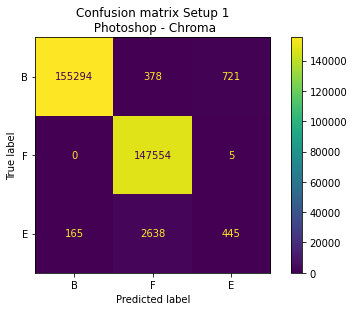

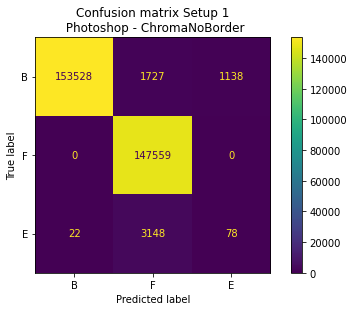

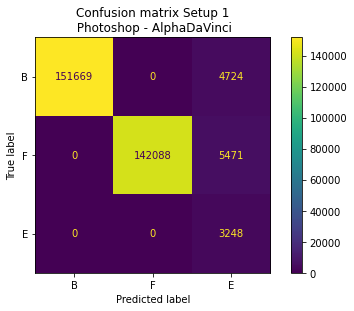

In [6]:

Frame = ['Me']
#Frame = ['Karate','KungFu','OldMan','Scientist','Me','Prof','Seat']
#file = open("/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/Confusion_matrix_alpha_binaria.txt", "w")
for f in Frame:
    print(f)
    #file.write('%s\n' % f)
    if f == 'Me' or f == 'Prof' or f == 'Seat':
        trueName = 'Photoshop'
        prog = ['Chroma','ChromaNoBorder','AlphaDaVinci']
    else:
        trueName = 'Paper'
        prog = ['Chroma','ChromaNoBorder','AlphaDaVinci']

    true = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/%s.png' % (f,trueName), cv2.IMREAD_UNCHANGED)
    true = true.astype(float)
    true = true[:,:,3]/255
    true = classifier(true)
   
    for p in prog:
        pred = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/%s.png' % (f,p), cv2.IMREAD_UNCHANGED)
        pred = pred.astype(float)
        pred = pred[:,:,3]/255
        
        if p == 'AlphaDaVinci':
            deltaSx = 0.18
        else:
            deltaSx = 0.01
        pred = classifier(pred,deltaSx)
        
        
        precision =  sk.precision_score(true,pred,average='macro')
        recall = sk.recall_score(true,pred,average='macro',zero_division='warn')
        accuracy = sk.accuracy_score(true,pred)
        f1_score = sk.f1_score(true,pred,average='macro')
        
        
        cm = sk.confusion_matrix(true, pred)
        disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['B', 'F', 'E']) #classifier
        #disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['B', 'Rest']) #classifier0
        #disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['F', 'Rest']) #classifier1
        #disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['E', 'Rest']) #classifier2
        
        
        disp.plot()
        plt.tight_layout()
        plt.title("Confusion matrix Setup 1\n %s - %s" % (trueName,p))
        plt.savefig('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/ConfMatrix/SetUp1%s_%s.pdf' % (f,trueName,p), bbox_inches='tight', pad_inches=0.1)

        print("Confusion matrix di %s tra alpha%s e alpha%s\nprecision = %s\nrecall = %s\naccuracy = %s\nF1_score = %s\n" % (f,trueName,p,precision,recall,accuracy,f1_score))
        #file.write("Confusion matrix di %s tra alpha%s e alpha%s\nprecision = %s\nrecall = %s\naccuracy = %s\nF1_score = %s \n\n" % (f,trueName,p,precision,recall,accuracy,f1_score))
    #file.write("\n")
#file.close()

## Plot Hist From Confusion Matrix Score

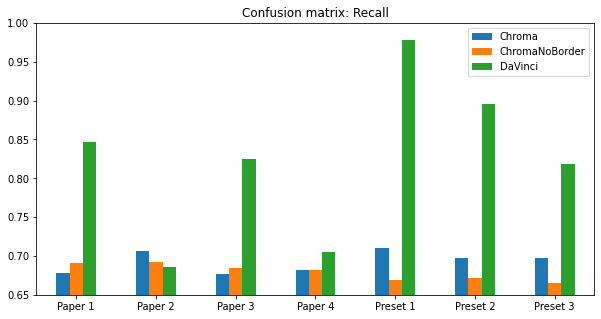

In [12]:
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
    
#List = ['Precision','Recall','Accuracy','F1']
List = ['Recall']
Frame = ['Karate','OldMan','KungFu','Scientist','Me','Prof','Seat']
Name = ['Paper 1', 'Paper 2', 'Paper 3', 'Paper 4', 'Preset 1','Preset 2','Preset 3']
#Frame = ['Karate','Me']
#Frame = ['Karate']


for l in List:
    chromaScore = []
    chromaNBScore = []
    daVinciScore = []
    for f in Frame:
        if f == 'Me' or f == 'Prof' or f == 'Seat':
            trueName = 'Photoshop'
            prog = ['Chroma','ChromaNoBorder','AlphaDaVinci']
        else:
            trueName = 'Paper'
            prog = ['Chroma','ChromaNoBorder','AlphaDaVinci']

        true = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/%s.png' % (f,trueName), cv2.IMREAD_UNCHANGED)
        true = true.astype(float)
        true = true[:,:,3]/255
        true = classifier(true)

        for p in prog:
            pred = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/%s/%s.png' % (f,p), cv2.IMREAD_UNCHANGED)
            pred = pred.astype(float)
            pred = pred[:,:,3]/255

            if p == 'AlphaDaVinci':
                deltaSx = 0.18
            else:
                deltaSx = 0.01
            pred = classifier(pred,deltaSx)

            if l == 'Precision':
                score =  sk.precision_score(true,pred,average='macro')
            if l == 'Recall':
                score = sk.recall_score(true,pred,average='macro',zero_division='warn')
            if l == 'Accuracy':
                score = sk.accuracy_score(true,pred)
            if l == 'F1':
                score = sk.f1_score(true,pred,average='macro')

            if p == 'Chroma':
                chromaScore.append(score)
            if p == 'ChromaNoBorder':
                chromaNBScore.append(score)
            if p == 'AlphaDaVinci':
                daVinciScore.append(score)
    
    df = pd.DataFrame({'Chroma': chromaScore,
                       'ChromaNoBorder': chromaNBScore,
                       'DaVinci': daVinciScore}, index=Name)
    ax = df.plot.bar(rot=0,figsize=(10,5))

    ax.set_title('Confusion matrix: %s' % l)
    ax.set_yscale('linear')
    ax.set_ylim([0.65, 1])
    #ax.set_yticks(np.arange(0.875, 1, 0.025))

    plt.savefig('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Compare/ConfusionMatrixScore/%sok.pdf' % l, bbox_inches='tight', pad_inches=0.1)
    plt.show()


## Alpha compare

In [ ]:
Frame = ['Karate','KungFu','OldMan','Scientist','Me','Prof']
file = open("Bench/Compare/Comparazioni_alpha.txt", "w")
for f in Frame:
    alphaChroma = cv2.imread('Bench/Compare/%s/Chroma.png' % f, cv2.IMREAD_UNCHANGED)
    alphaChroma = cv2.cvtColor(alphaChroma, cv2.COLOR_BGR2BGRA)
    alphaChroma = alphaChroma.astype(float)
    alphaChroma = alphaChroma[:,:,3]/255
    prog = ['DaVinci','DaVinciBetter'] if f == 'Me' or f == 'Prof' else ['DaVinci','DaVinciBetter','Paper']
    for p in prog:
        if p == 'DaVinci' or 'DaVinciBetter':
            alphaDaVinci = cv2.imread('Bench/Compare/%s/%s.png' % (f,p))
            alphaDaVinci = alphaDaVinci.astype(float)
            alphaDaVinci = alphaDaVinci[:,:,2]/255
            diff = np.sum(np.abs(np.subtract(alphaChroma,alphaDaVinci)))
            img = np.subtract(alphaChroma,alphaDaVinci)
            img = img*255
            cv2.imwrite("Bench/Compare/Difference Img/%s/%s_Chroma_%s.png" % (f,f,p),img)
            print("Differenza %s tra alphaChroma e alpha%s = %s" % (f,p,diff))
            file.write("Differenza %s tra alphaChroma e alpha%s = %s\n" % (f,p,diff))
        elif p == 'Paper':
            alphaPaper = cv2.imread('Bench/Compare/%s/%s.png' % (f,p), cv2.IMREAD_UNCHANGED)
            alphaPaper = cv2.cvtColor(alphaPaper, cv2.COLOR_BGR2BGRA)
            alphaPaper = alphaPaper.astype(float)
            alphaPaper = alphaPaper[:,:,3]/255
            diff = np.sum(np.abs(np.subtract(alphaChroma,alphaPaper)))
            img = np.subtract(alphaChroma,alphaPaper)
            img = img*255
            cv2.imwrite("Bench/Compare/Difference Img/%s/%s_Chroma_Paper.png" % (f,f),img)
            print("Differenza %s tra alphaChroma e alphaPaper = %s" % (f,diff))
            file.write("Differenza %s tra alphaChroma e alphaPaper = %s\n" % (f,diff))
    file.write("\n")
file.close()

## Frame extractor

In [42]:
#FRAME EXTRACTOR
import cv2
name = 'Seat'
#pic = ['Red','Green','Chess']
pic = ['ciao']
for pic in pic:
    vidcap = cv2.VideoCapture('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Seat/File estrazione alpha/%s%s.avi' % (name,pic))
    success,image = vidcap.read()
    count = 0
    while count < 1:
        cv2.imwrite("/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Seat/File estrazione alpha/%s%sBetter.png" % (name,pic), image)     # save frame as JPEG file      
        success,image = vidcap.read()
        print('Read a new frame: ', success)
        count += 1
alphaExtractor(name)

Read a new frame:  True


## Video Compositor

In [ ]:
#VIDEO Creator
import cv2
import numpy as np

img = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/Paper-Disney/KeyingResults/Karate/0.png', cv2.IMREAD_UNCHANGED)
height, width, layers = img.shape
size = (width,height)
out = cv2.VideoWriter('/Users/robertocraparotta/Desktop/KaratepngbUNCHANGED.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, size)
for i in range(121):
    img = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/Paper-Disney/KeyingResults/Karate/%s.png'  % i)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    out.write(img)
    i += 1

out.release()
del out



## Background Export

In [ ]:
base_image_BGR = cv2.imread('Bench/OldMan/OldMan.png')
newBackground = chroma.checkboard(np.zeros_like(base_image_BGR, dtype=np.uint8))
cv2.imwrite("Bench/OldMan/sfondoChess.png", newBackground)

## Alpha Extractor

In [ ]:
def alphaExtractor(name):    
    imageGreen = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Seat/File estrazione alpha/%sGreenBetter.png' % name) #LEGGO L'IMMAGINE CON LO SFONDO VERDE
    imageRed = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Seat/File estrazione alpha/%sRedBetter.png' % name) #LEGGO L'IMMAGINE CON LO SFONDO ROSSO
    imageGreen = imageGreen.astype(int) #TRASFORMO IL TIPO IN INT
    imageRed = imageRed.astype(int) #TRASFORMO IL TIPO IN INT
    r1 = imageGreen[:,:,2]
    r2 = imageRed[:,:,2]
    alpha = np.clip(255 - r2 + r1, 0, 255)
    cv2.imwrite('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Seat/File estrazione alpha/%sAlphaChannelBetter.png' % name,alpha) # SALVO L'IMMAGINE



## Ricostruzione con Alpha

In [ ]:
def prova(foreground, background, alphamask):
    # remember the old datatype
    old_type = background.dtype
    # Convert uint8 to float
    alphamask = np.stack([alphamask]*4, axis=2)
    foreground = cv2.multiply(alphamask, foreground.astype(float))
    background = background.astype(float)
    background = cv2.multiply(1.0-alphamask, background)
    # Add the masked foreground and background
    background = cv2.add(background,foreground)
    outImage = background.astype(old_type)
    return outImage


image = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Karate/Karate.png')
green = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Karate/File estrazione alpha/KarateRed.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
green = cv2.cvtColor(green, cv2.COLOR_BGR2BGRA)


imageAlpha = cv2.imread('/Users/robertocraparotta/Desktop/Tesi/ChromaDespill/Bench/Karate/KarateAlphaChannel.png')

image = image.astype(float) #TRASFORMO IL TIPO IN INT
green = green.astype(float) #TRASFORMO IL TIPO IN INT
imageAlpha = imageAlpha.astype(float)

imageAlpha = imageAlpha/255
#image[:,:,3] = imageAlpha[:,:,2]



# Apply despill
despMask, despilled = chroma.despill2(image, sensitivity=0.96, doRamp=True) # borderMask if addBorder else
despMask = np.minimum(despMask, imageAlpha[:,:,2])
    
# compose with background 
srcCompose = despilled
image = prova(srcCompose,green,imageAlpha[:,:,2])


cv2.imwrite('/Users/robertocraparotta/Desktop/AAAAAA.png',image) # SALVO L'IMMAGINE